# LAB | Hyperparameter Tuning

**Load the data**

Finally step in order to maximize the performance on your Spaceship Titanic model.

The data can be found here:

https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv

Metadata

https://github.com/data-bootcamp-v4/data/blob/main/spaceship_titanic.md

So far we've been training and evaluating models with default values for hyperparameters.

Today we will perform the same feature engineering as before, and then compare the best working models you got so far, but now fine tuning it's hyperparameters.

In [1]:
#Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
spaceship = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv")
spaceship.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Now perform the same as before:
- Feature Scaling
- Feature Selection


In [8]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

# Carga datos
spaceship = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv")

# Definir target
y = spaceship['Transported']

# Seleccionar features y eliminar columnas irrelevantes o con demasiados valores únicos
X = spaceship.drop(columns=['Transported', 'PassengerId', 'Name', 'Cabin', 'Destination', 'HomePlanet'])

# Separar numéricas y categóricas
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

# Imputar numéricas con media
imputer_num = SimpleImputer(strategy='mean')
X[num_cols] = imputer_num.fit_transform(X[num_cols])

# Imputar categóricas con constante 'missing'
imputer_cat = SimpleImputer(strategy='constant', fill_value='missing')
X[cat_cols] = imputer_cat.fit_transform(X[cat_cols])

# One-hot encoding para categóricas
X = pd.get_dummies(X, drop_first=True)

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature Selection: seleccionar todas las features (evitamos error k>n_features)
selector = SelectKBest(score_func=f_classif, k='all')
X_selected = selector.fit_transform(X_scaled, y)

print(f"Original features: {X.shape[1]}, Selected features: {X_selected.shape[1]}")


Original features: 10, Selected features: 10


- Now let's use the best model we got so far in order to see how it can improve when we fine tune it's hyperparameters.

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score

# Split de datos (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Modelo base
rf = RandomForestClassifier(random_state=42)

# Parámetros para tunear
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Búsqueda random con 20 iteraciones y 3-fold CV
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=20, cv=3, verbose=2,
                                   random_state=42, n_jobs=-1)

# Entrenar búsqueda
random_search.fit(X_train, y_train)

# Mejor modelo
best_rf = random_search.best_estimator_
print("Mejores hiperparámetros:", random_search.best_params_)

# Evaluar en test
y_pred = best_rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy en test set: {acc:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  

- Evaluate your model

Matriz de confusión:
[[ 933  356]
 [ 196 1123]]

Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.83      0.72      0.77      1289
        True       0.76      0.85      0.80      1319

    accuracy                           0.79      2608
   macro avg       0.79      0.79      0.79      2608
weighted avg       0.79      0.79      0.79      2608


ROC AUC: 0.8368


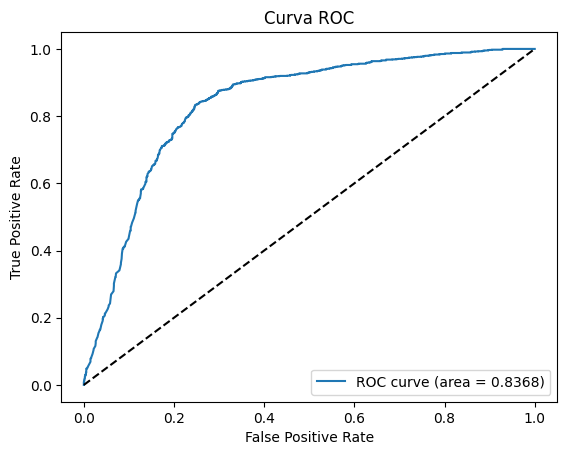

In [10]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predecimos sobre test
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]  # Probabilidad clase positiva

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
print(cm)

# Reporte clasificación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# ROC AUC
auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC: {auc:.4f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.4f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


**Grid/Random Search**

For this lab we will use Grid Search.

- Define hyperparameters to fine tune.

In [11]:
param_grid = {
    'n_estimators': [100, 200, 300],          # número de árboles
    'max_depth': [None, 10, 20, 30],          # profundidad máxima de cada árbol
    'min_samples_split': [2, 5, 10],          # mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],             # mínimo de muestras en una hoja
    'bootstrap': [True, False]                 # si usar bootstrap o no
}


- Run Grid Search

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

# Partimos los datos (si no lo tienes ya hecho)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Modelo base
rf = RandomForestClassifier(random_state=42)

# Grid de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],          
    'max_depth': [None, 10, 20, 30],          
    'min_samples_split': [2, 5, 10],          
    'min_samples_leaf': [1, 2, 4],             
    'bootstrap': [True, False]                 
}

# GridSearchCV con 3 folds CV y uso máximo de CPUs
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           verbose=2)

# Entrenamos el grid search
grid_search.fit(X_train, y_train)

# Mejor modelo
best_rf = grid_search.best_estimator_
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Evaluación en test
y_pred = best_rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy en test: {acc:.4f}")


Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; tota

- Evaluate your model

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predecimos etiquetas y probabilidades sobre test
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]  # probabilidad clase positiva

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
print(cm)

# Reporte de métricas detallado
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# ROC AUC
auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC: {auc:.4f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.4f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
